# Trabalho Prático 1 de Introdução à Computação Visual

**Aluno 1:** Pedro de Oliveira Guedes

**Aluno 2:** ??? (**Matrícula:** ???)

O presente trabalho tem por objetivo a implementação de um algoritmo de compressão, buscando exercitar os conceitos estudados em sala de aula durante a matéria de Introdução à Computação Visual. Somente serão trabalhadas imagens em tons de cinza.

O algoritmo escolhido foi o **JPEG**, que é um dos algoritmos de compressão de imagens mais utilizados no mundo. O JPEG é um **algoritmo de compressão COM perdas**, ou seja, a imagem comprimida não é exatamente igual à original.

De forma resumida, o algoritmo JPEG funciona da seguinte forma:

1. Divisão da imagem de entrada completa em blocos de 8x8 pixels.

2. Aplicação de transformada em cada um dos blocos.
    * A transformada utilizada é a ***Discrete Cosine Transform (DCT)***, ou Transformada Discreta do Cosseno.

    * A justificativa para a utilização da DCT em oposição à ***DFT (Discrete Fourier Transform)*** será explicada em mais detalhes posteriormente.

3. Divisão do bloco transformado pela chamada "**Matriz de Quantização**", que também é uma matriz 8x8 com coeficientes pré-definidos que, quanto maior forem, mais perda de informação haverá.

4. Codificação por entropia dos coeficientes resultantes da etapa anterior, gerando uma tabela de codificação.

Para a realização deste trabalho, será utilizada a linguagem de programação Python, com auxílio das bibliotecas NumPy, para lidar com as manipulações matemáticas, e OpenCV, para lidar com a leitura e escrita de imagens.

## Principais bibliotecas utilizadas
Para a implementação do algoritmo, serão utilizadas três dependências principais:

1. **NumPy**: Biblioteca para manipulação de arrays multidimensionais e realização de operações matemáticas.

2. **Matplotlib**: Biblioteca para visualização de gráficos e imagens.

3. **OpenCV**: Biblioteca para manipulação de imagens.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as opencv

## Funções auxiliares
Ao longo da implementação, serão utilizadas algumas funções auxiliares, como de visualização das imagens, para facilitar a compreensão do código. Essas funções serão definidas a seguir.

### Visualização de imagens
O método `imshow` da biblioteca do OpenCV está sofrendo conflitos quando o código é executado em arquivos Jupyter Notebook, que é o caso deste trabalho.

Para contornar esse problema, será definida uma função auxiliar `show_images` que utiliza a biblioteca Matplotlib para exibir as imagens.

Essa função receberá um dicionário, cujas chaves são os títulos das imagens e os valores são as imagens em si. As imagens recebidas serão exibidas em um grid, facilitando a visualização e a comparação entre elas.

In [ ]:
def show_images(images: dict[str, opencv.typing.MatLike]) -> None:
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.set_title(name)
        ax.axis("off")
        ax.imshow(image, cmap="gray")

    plt.show()

### Adição de bordas para imagens
Em alguns casos pode ser necessário adicionar bordas a uma imagem para o processamento. Um exemplo disso é a primeira etapa do algoritmo JPEG, onde a divisão da imagem em blocos de 8x8 pixels pode ser feita em uma imagem original cujas dimensões não são múltiplas de 8.

Para contornar esse problema, será definida uma função `add_padding` que adiciona bordas à imagem de acordo com a dimensão atual e a dimensão desejada, dividindo a diferença entre as dimensões igualmente entre os lados superior, inferior, esquerdo e direito.

A biblioteca `math` será utilizada para arredondar os valores resultantes da divisão.

In [ ]:
import math

def pad_image(
    image: opencv.typing.MatLike,
    final_height: int,
    final_width: int,
    border_type: int = opencv.BORDER_CONSTANT,
) -> opencv.typing.MatLike:
    height, width = image.shape

    if height >= final_height and width >= final_width:
        return image
    
    top = math.ceil((final_height - height) / 2)
    bottom = math.floor((final_height - height) / 2)
    left = math.ceil((final_width - width) / 2)
    right = math.floor((final_width - width) / 2)

    return opencv.copyMakeBorder(
        src=image,
        top=top,
        bottom=bottom,
        left=left,
        right=right,
        borderType=border_type,
        dst=None,
    )

## Processo de compressão
Nesta seção, será detalhado o processo de compressão de imagens utilizando o algoritmo JPEG, exemplificando cada uma das etapas com algoritmos e imagens dos resultados preliminares.

### 1. Divisão da imagem em blocos de 8x8 pixels
A primeira etapa do algoritmo JPEG consiste em dividir a imagem de entrada em blocos de 8x8 pixels, que serão processados individualmente ao longo do algoritmo, até a etapa final de compressão, onde serão codificados e armazenados em conjunto.

Separar esse blocos previamente no código facilita a implementação das etapas seguintes, evitando a necessidade de iterar sobre a imagem original a cada etapa.

In [13]:
def divide_image_in_blocks(image: opencv.typing.MatLike, block_size: tuple[int, int] = (8, 8)) -> list[opencv.typing.MatLike]:
    blocks = []
    rows, cols = image.shape
    block_rows, block_cols = block_size
    if rows % block_rows != 0 or cols % block_cols != 0:
        image = pad_image(
            image=image,
            final_height=math.ceil(rows / block_rows) * block_rows,
            final_width=math.ceil(cols / block_cols) * block_cols,
        )

    for i in range(0, rows, block_rows):
        for j in range(0, cols, block_cols):
            block = image[i:i + block_rows, j:j + block_cols]
            blocks.append(block)

    return blocks

#### 1.1. Reconstrução da imagem dividida em blocos
Após o processamento dos blocos 8x8, é necessário reconstruir a imagem original.

In [ ]:
def reconstruct_image_from_blocks(
    blocks: list[opencv.typing.MatLike],
    image_shape: tuple[int, int],
    add_grid: bool = False,
) -> opencv.typing.MatLike:
    rows, cols = image_shape

    block_rows, block_cols = blocks[0].shape

    image = np.zeros((rows, cols), dtype=np.uint8)
    block_index = 0
    for i in range(0, rows, block_rows):
        for j in range(0, cols, block_cols):
            block = blocks[block_index]
            image[i:i + block_rows, j:j + block_cols] = block
            block_index += 1

    if add_grid:
        for i in range(0, rows, block_rows):
            image = opencv.line(image, (0, i), (cols, i), 0, 1)
        for j in range(0, cols, block_cols):
            image = opencv.line(image, (j, 0), (j, rows), 0, 1)

    return image

#### 1.2. Exemplo
Para exemplificar e testar a divisão da imagem em blocos, será utilizada a imagem `lena512.pgm` presente na pasta `images` deste repositório. 

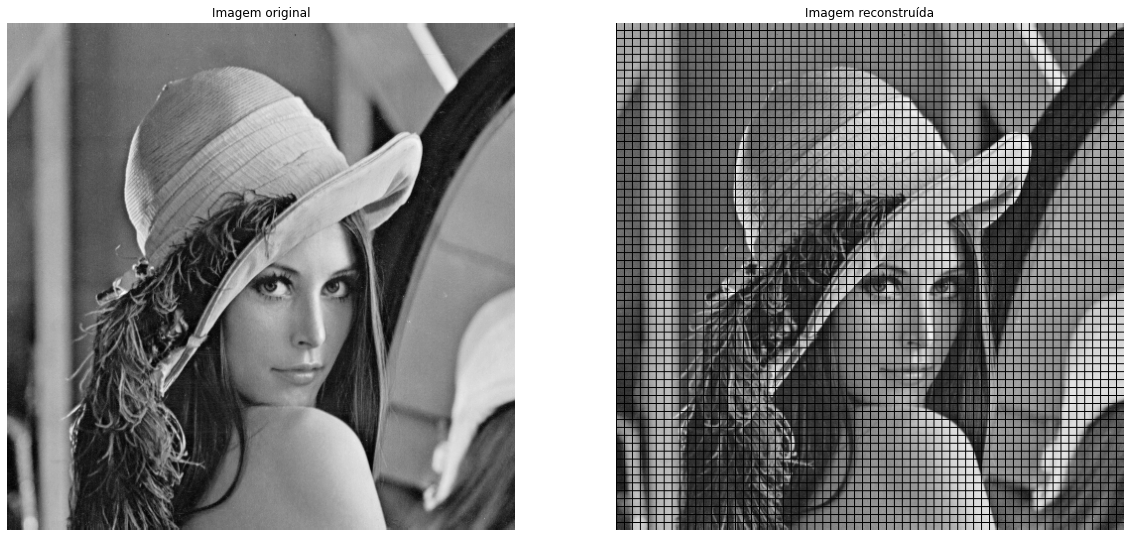

In [20]:
original_image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)
blocks = divide_image_in_blocks(original_image)
reconstructed_image = reconstruct_image_from_blocks(blocks, original_image.shape, add_grid=True)

show_images({"Imagem original": original_image, "Imagem reconstruída": reconstructed_image})